# 本博客是对gumbel_softmax相关内容的探索和记录

## 1. gumbel_softmax有什么用呢?
假设如下场景: 
模型训练过程中, 网络的输出为p = [0.1, 0.7, 0.2], 三个概率的输出分别为"向左", "向上", "向右". 我们的做法可能是y = argmax(p), 也即选择"向上"这条决策.
这样做会有两个问题:
1. argmax()函数是不可导的.这样网络就无法进行反向传播进行学习.
2. argmax()的选择不具有随机性.同样的p选择100次,每次的结果都为"向上".而按照概率为0.7的含义,100次应该有70次左右的决策结果是选择"向上".

而gumbel_softmax的作用就是解决上述这两个子问题.

## 2.argmax(x)是什么?为什么不可导?
为了更直观,这里使用两维的vector
y = argmax(x); x = (x1, x2)

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

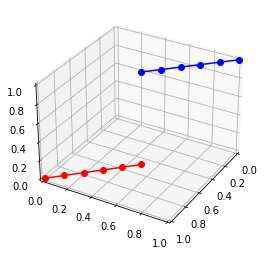

In [22]:
# 绘制argmax()的第一段
xs = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
ys = [0.5, 0.4, 0.3, 0.2 , 0.1, 0.0]
zs = [0, 0, 0, 0, 0, 0]
fig = plt.figure()
ax = fig.add_axes((0.1,0.1,0.8,0.8), projection='3d')
ax.plot3D(xs, ys, zs, c='red', marker='o')
ys = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
xs = [0.5, 0.4, 0.3, 0.2 , 0.1, 0.0]
zs = [1, 1, 1, 1, 1, 1]
ax.plot3D(xs, ys, zs, c='blue', marker='o')
plt.xlim(0, 1)
plt.ylim(0, 1)
ax.view_init(azim=30, elev=30)
plt.show()

多元函数可微分的充分条件是函数连续且具有偏导数.
从argmax的三维图可以看出, argmax(x), 首先在x1 = x2处不连续,因此在该点处必定是不可导的.
在红线处, 保持x1不变, 求 y相对于x2的偏微分,发现是不存在的.因为x1不变的情况下,x2也是无法有一个微小的变动.
故, argmax()函数不可微分.

## 3. 引入随机性：gumbel分布
为了在y=argmax(p)中引入随机性, 将其修改为y = argmax(log(p) + G).G称之为gumbel分布, 它的数学表达式为G=-log(-log($\xi$)))。引入该分布的作用是引入了随机性，且该随机性保证了该分布输出i的概率等于pi。下面是科学空间上的证明，比较容易理解。

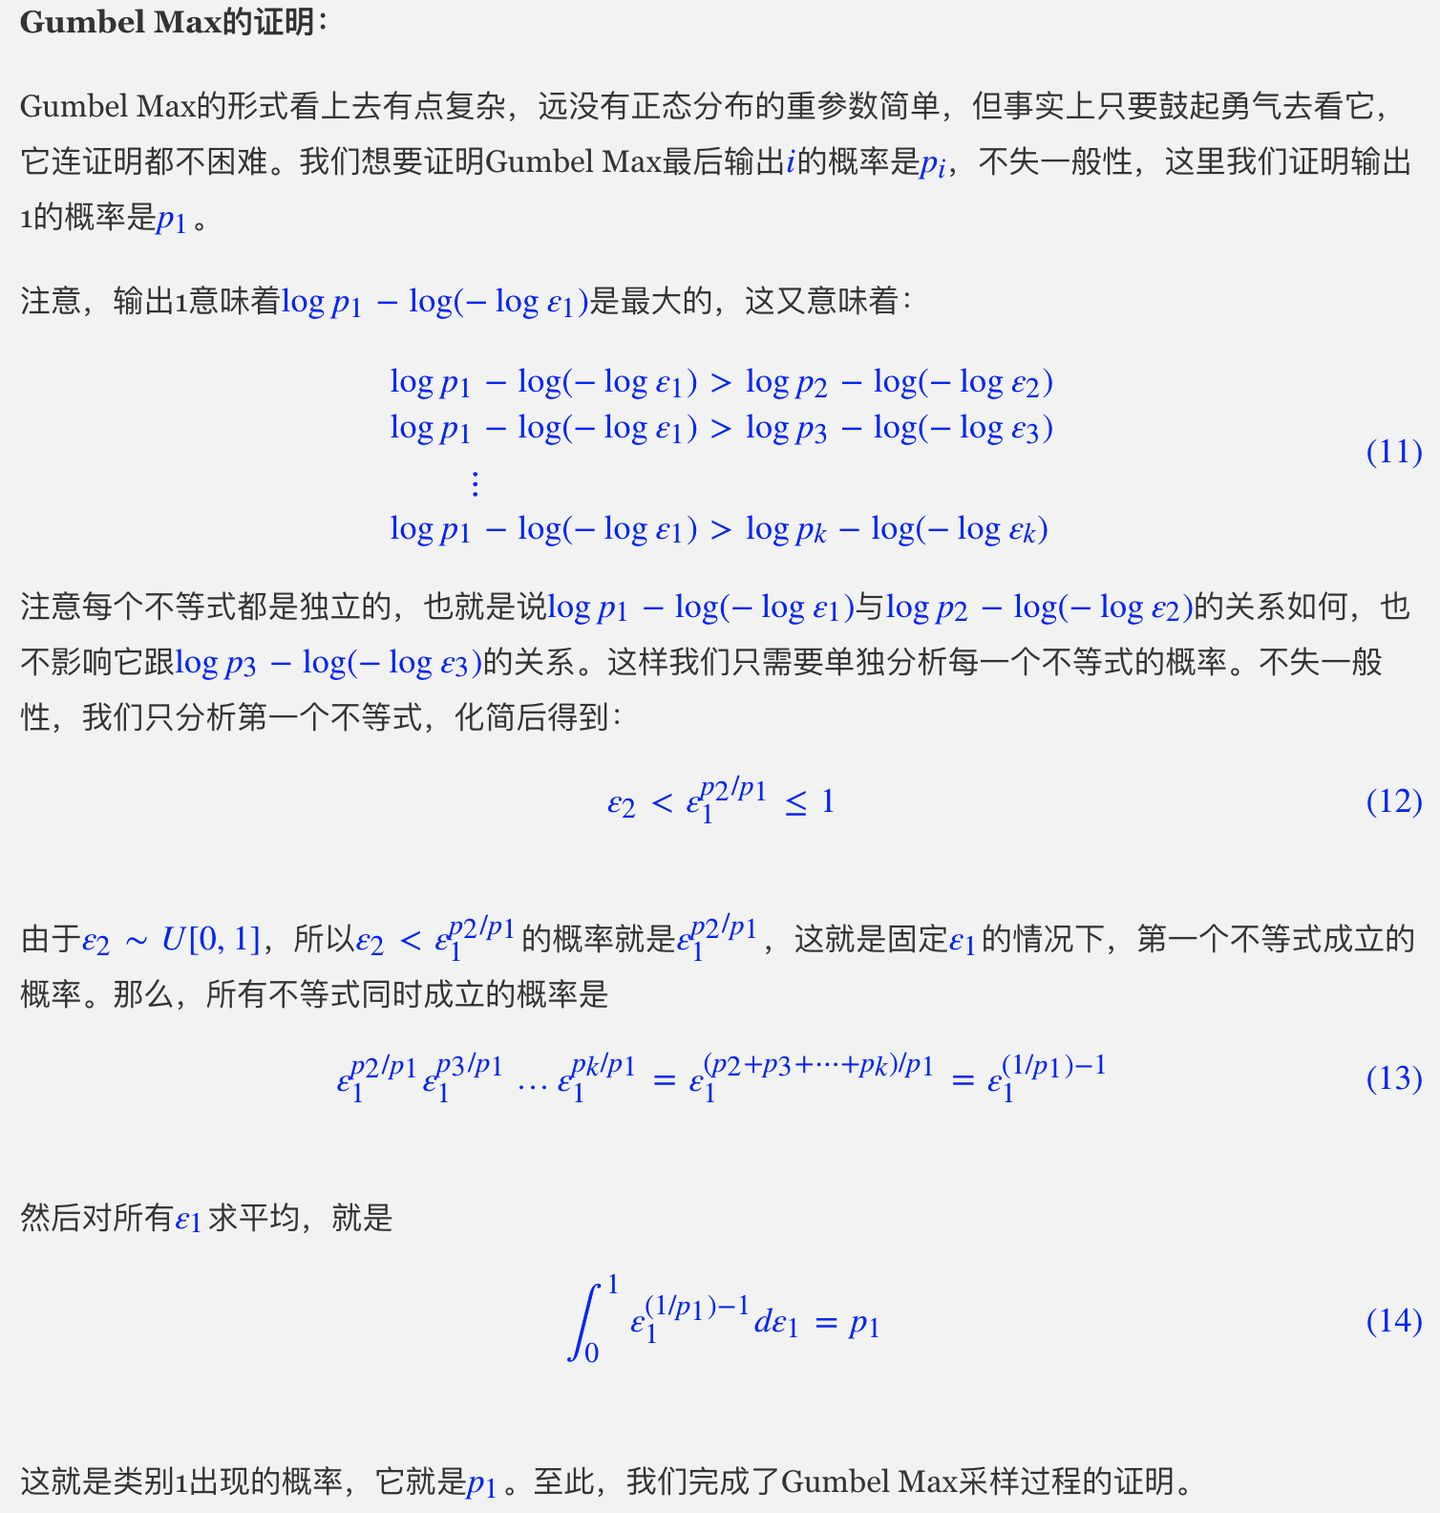

## 4. 解决不可导：gumbel_softmax
1. 解决不可导的方法可以用gumbel_softmax来处理。也即forward阶段，使用argmax操作，暂时不用管后面反向操作;但在反向阶段则使用gumbel_softmax来做bp计算，可以通过看pytorch中相关代码块有一个很清晰的认知。


In [ ]:
def gumbel_softmax(logits: Tensor, tau: float = 1, hard: bool = False, eps: float = 1e-10, dim: int = -1) -> Tensor:
    。。。
    gumbels = (
        -torch.empty_like(logits, memory_format=torch.legacy_contiguous_format).exponential_().log()
    )  # ~Gumbel(0,1)
    gumbels = (logits + gumbels) / tau  # ~Gumbel(logits,tau)
    y_soft = gumbels.softmax(dim)

    if hard:
        # Straight through.
        index = y_soft.max(dim, keepdim=True)[1]
        y_hard = torch.zeros_like(logits, memory_format=torch.legacy_contiguous_format).scatter_(dim, index, 1.0)
        ret = y_hard - y_soft.detach() + y_soft
    else:
        # Reparametrization trick.
        ret = y_soft
    return ret

2. 这样做是没有问题的，但是前向的y_hard,与y_softmax我们还是要尽可能缩小它们之间的“误差”，因此gumbel_softmax中引入了温度t, t越小，softmax就越接近One-hot。为了训练稳定性，一般t会取一个比较大的数字，然后逐步缩小。

This repo contains an introduction to [Jupyter](https://jupyter.org) and [IPython](https://ipython.org).

Outline of some basics:

* [Notebook Basics](../examples/Notebook/Notebook%20Basics.ipynb)
* [IPython - beyond plain python](../examples/IPython%20Kernel/Beyond%20Plain%20Python.ipynb)
* [Markdown Cells](../examples/Notebook/Working%20With%20Markdown%20Cells.ipynb)
* [Rich Display System](../examples/IPython%20Kernel/Rich%20Output.ipynb)
* [Custom Display logic](../examples/IPython%20Kernel/Custom%20Display%20Logic.ipynb)
* [Running a Secure Public Notebook Server](../examples/Notebook/Running%20the%20Notebook%20Server.ipynb#Securing-the-notebook-server)
* [How Jupyter works](../examples/Notebook/Multiple%20Languages%2C%20Frontends.ipynb) to run code in different languages.

You can also get this tutorial and run it on your laptop:

    git clone https://github.com/ipython/ipython-in-depth

Install IPython and Jupyter:

with [conda](https://www.anaconda.com/download):

    conda install ipython jupyter

with pip:

    # first, always upgrade pip!
    pip install --upgrade pip
    pip install --upgrade ipython jupyter

Start the notebook in the tutorial directory:

    cd ipython-in-depth
    jupyter notebook